<a href="https://colab.research.google.com/github/jwdagney55/DSPS_JDagney/blob/main/HW/HW10_aenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for DSPS2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

In [4]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd /content/gdrive/Shareddrives/


/content/gdrive/Shareddrives


In [6]:
ls

 DSPS2021/  'Redding 3C'/  'RockSat 2020'/


In [7]:
cd  DSPS2021/

/content/gdrive/Shareddrives/DSPS2021


# 1A  (661) load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [8]:
flist = glob.glob("data/faces95/*jpg")

In [9]:
N = len(flist)
N

1440


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

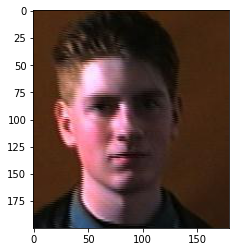

In [10]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

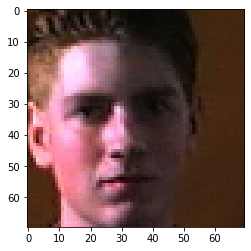

In [11]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'> 461 students - you can skip this and go  straight to loading the images</font>

In [12]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
#imgs = np.zeros((N, 70, 70, 1))
#for i,f in enumerate(flist):
#  if not i%50: print(i)
#  im = Image.open(flist[i])
#  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
#  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
#  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

# 461 studentd - 1B you can read the images below if you have saved them earlier

In [13]:
imgs = np.load("data/faces.npy")
imgs.shape

(1440, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)


In [14]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [15]:
imgs.shape

(1440, 70, 70, 1)

In [16]:
# lower the resolution
# example: take one every N pixels
step = 2
imgs_lr = imgs[:,::step,::step]
# slightly better than the line of code above
#imgs_lr = imgs.reshape(...).mean().mean()
imgs_lr.shape

(1440, 35, 35, 1)

In [17]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [18]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr,imgs_orig,test_size=.2)

In [19]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 35, 35, 1), (288, 35, 35, 1), (1152, 70, 70, 1), (288, 70, 70, 1))

In [20]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [21]:
#X_tr = X_tr.reshape(len(X_tr), X_tr.shape[1], X_tr.shape[2], 1)

In [22]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 1225), (288, 1225), (1152, 4900), (288, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [23]:
from tensorflow import keras
from keras import optimizers

In [79]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
#model.add(Conv2D(324, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
#model.add(Conv2D(256, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
#model.add(Conv2D(128, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
#model.add(Conv2D(256, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
#model.add(Conv2D(1225, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
#model.add(Conv2D(4900, kernel_size = (1, 1 ), strides = (1,1), activation='relu'))#input_dim=1225
#model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dense(1225, activation='relu', input_dim=1225))
#model.add(Dense(324, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(4900, activation='relu'))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss="mean_squared_error")

In [80]:

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1225)              1501850   
                                                                 
 dense_13 (Dense)            (None, 256)               313856    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dense_16 (Dense)            (None, 1225)              314825    
                                                                 
 dense_17 (Dense)            (None, 4900)              6007400   
                                                                 
Total params: 8,203,851
Trainable params: 8,203,851
No

## 4 A train model 

In [86]:
# you can skip this and load the saved model
history = model.fit(X_tr,y_tr,validation_data=(X_te,y_te), epochs=500, batch_size=600, verbose=1)

Epoch 1/500
2/2 [==============================] - 0s 107ms/step - loss: 0.0171 - val_loss: 0.0206
Epoch 2/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0172 - val_loss: 0.0202
Epoch 3/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0169 - val_loss: 0.0203
Epoch 4/500
2/2 [==============================] - 0s 69ms/step - loss: 0.0170 - val_loss: 0.0203
Epoch 5/500
2/2 [==============================] - 0s 69ms/step - loss: 0.0171 - val_loss: 0.0204
Epoch 6/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0171 - val_loss: 0.0202
Epoch 7/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0171 - val_loss: 0.0203
Epoch 8/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0171 - val_loss: 0.0203
Epoch 9/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0170 - val_loss: 0.0201
Epoch 10/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0169 - val_loss: 0.0205
Epoch 11/500
2/2 [

## predict

In [87]:
outim = model.predict(X_te)
outim

array([[0.46930474, 0.46698356, 0.47477737, ..., 0.43683016, 0.41773584,
        0.        ],
       [0.5112696 , 0.5075008 , 0.5144664 , ..., 0.20447679, 0.2057932 ,
        0.        ],
       [0.21215081, 0.21297139, 0.21069583, ..., 0.27917552, 0.26199284,
        0.        ],
       ...,
       [0.27202636, 0.26706263, 0.26798165, ..., 0.15062949, 0.14785846,
        0.        ],
       [0.20467718, 0.21260923, 0.2117044 , ..., 0.16737863, 0.16098712,
        0.        ],
       [0.26568452, 0.26212034, 0.26864934, ..., 0.25097066, 0.24948752,
        0.        ]], dtype=float32)

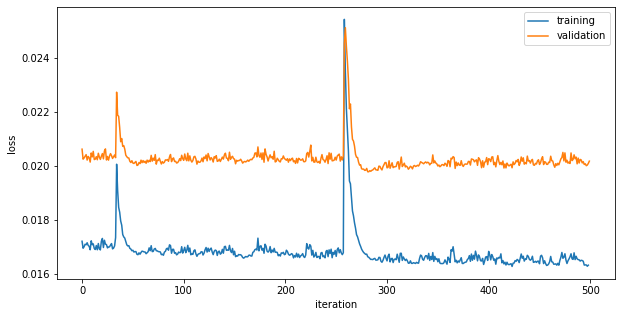

In [88]:
pl.plot(np.array(history.history['loss'][1:]), label="training")
pl.plot(np.array(history.history['val_loss']), label="validation")
pl.ylabel('loss')
pl.xlabel('iteration')

pl.legend()
#pl.yscale('log')
#pl.xscale('log')

In [84]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


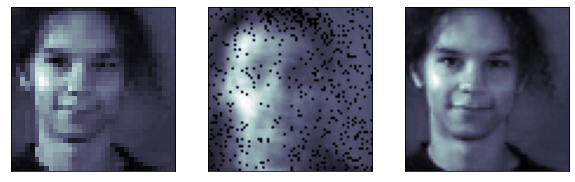

2 :	input		      prediction		  target


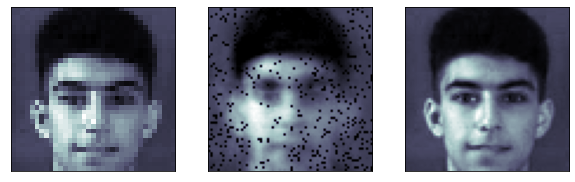

3 :	input		      prediction		  target


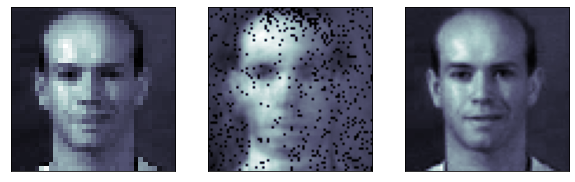

4 :	input		      prediction		  target


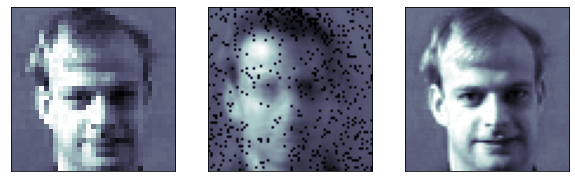

5 :	input		      prediction		  target


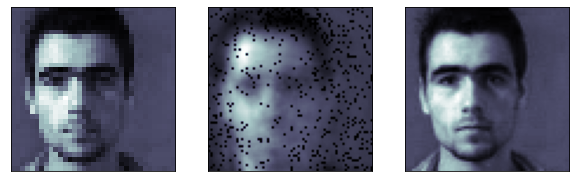

6 :	input		      prediction		  target


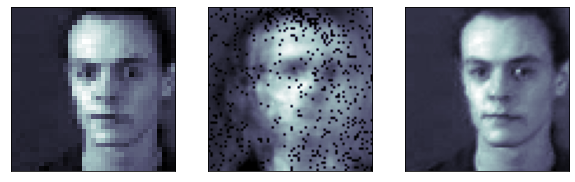

7 :	input		      prediction		  target


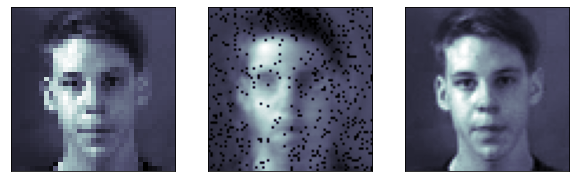

8 :	input		      prediction		  target


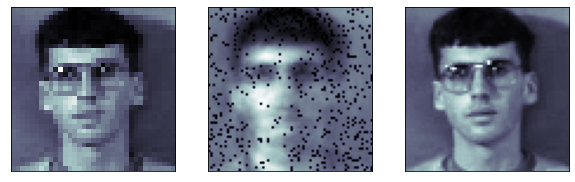

9 :	input		      prediction		  target


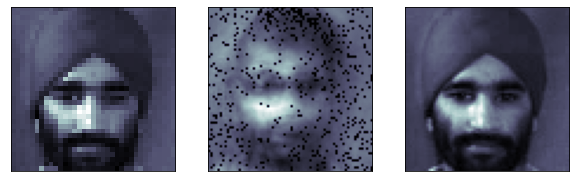

10 :	input		      prediction		  target


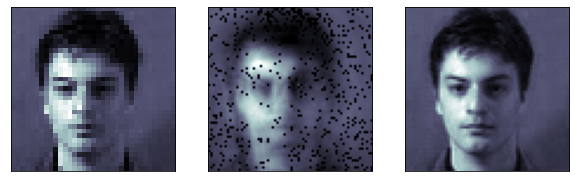

In [89]:
np.random.seed(123)
# pick a few random test images
for i in range(10):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## OPTIONA (EC): show the latent representation of the data: the bottleneck layer output

find a visualization that works for you

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [38]:
cd /content/gdrive/MyDrive/DSPS2021/

/content/gdrive/MyDrive/DSPS2021


In [39]:
ls

HiggsBoson/  IMG_0880.jpg  Titanic/


In [40]:
imme = Image.open("IMG_0880.jpg")


In [41]:
 np_imme = numpy.array(imme)[:,:,:1].astype(float) / 255 
 #numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 

In [42]:
step = 2
np_imme_lr = np_imme[::step,::step]
np_imme_lr.shape

(35, 35, 1)

In [43]:
np_imme.shape

(70, 70, 1)

In [44]:
real_lr = np_imme_lr.reshape(1,1225)
real_lr.shape

(1, 1225)

In [90]:
pre = model.predict(real_lr)

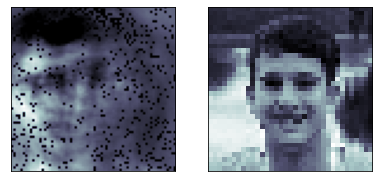

In [91]:
fig = pl.figure(figsize(10,5))
ax = fig.add_subplot(131) 
ax.imshow(pre.reshape(70,70) , cmap="bone")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = fig.add_subplot(132) 
ax.imshow(real_lr.reshape(35,35), cmap="bone")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# is it good? if not why not?
#It is not good. I think the problem is probably the background of the image. The model was trained on a solid color background, but my image was not solid. It looks like it is trying to put a face in the left side of the picture.